## Criticality Search
code taken from openmc examples

In [2]:
# Initialize third-party libraries and the OpenMC Python API
import matplotlib.pyplot as plt
import numpy as np

import openmc
import openmc.model

%matplotlib inline

## Create parametrized model

In [4]:
# Create the model. `ppm_Boron` will be the parametric variable.

def build_model(ppm_Boron):
    
    # Create the pin materials
    fuel = openmc.Material(name='1.6% Fuel')
    fuel.set_density('g/cm3', 10.31341)
    fuel.add_element('U', 1., enrichment=1.6)
    fuel.add_element('O', 2.)

    zircaloy = openmc.Material(name='Zircaloy')
    zircaloy.set_density('g/cm3', 6.55)
    zircaloy.add_element('Zr', 1.)

    water = openmc.Material(name='Borated Water')
    water.set_density('g/cm3', 0.741)
    water.add_element('H', 2.)
    water.add_element('O', 1.)

    # Include the amount of boron in the water based on the ppm,
    # neglecting the other constituents of boric acid
    water.add_element('B', ppm_Boron * 1e-6)
    
    # Instantiate a Materials object
    materials = openmc.Materials([fuel, zircaloy, water])
    
    # Create cylinders for the fuel and clad
    fuel_outer_radius = openmc.ZCylinder(r=0.39218)
    clad_outer_radius = openmc.ZCylinder(r=0.45720)

    # Create boundary planes to surround the geometry
    min_x = openmc.XPlane(x0=-0.63, boundary_type='reflective')
    max_x = openmc.XPlane(x0=+0.63, boundary_type='reflective')
    min_y = openmc.YPlane(y0=-0.63, boundary_type='reflective')
    max_y = openmc.YPlane(y0=+0.63, boundary_type='reflective')

    # Create fuel Cell
    fuel_cell = openmc.Cell(name='1.6% Fuel')
    fuel_cell.fill = fuel
    fuel_cell.region = -fuel_outer_radius

    # Create a clad Cell
    clad_cell = openmc.Cell(name='1.6% Clad')
    clad_cell.fill = zircaloy
    clad_cell.region = +fuel_outer_radius & -clad_outer_radius

    # Create a moderator Cell
    moderator_cell = openmc.Cell(name='1.6% Moderator')
    moderator_cell.fill = water
    moderator_cell.region = +clad_outer_radius & (+min_x & -max_x & +min_y & -max_y)

    # Create root Universe
    root_universe = openmc.Universe(name='root universe')
    root_universe.add_cells([fuel_cell, clad_cell, moderator_cell])

    # Create Geometry and set root universe
    geometry = openmc.Geometry(root_universe)
    
    # Instantiate a Settings object
    settings = openmc.Settings()
    
    # Set simulation parameters
    settings.batches = 300
    settings.inactive = 20
    settings.particles = 1000
    
    # Create an initial uniform spatial source distribution over fissionable zones
    bounds = [-0.63, -0.63, -10, 0.63, 0.63, 10.]
    uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
    settings.source = openmc.source.Source(space=uniform_dist)
    
    # We dont need a tallies file so dont waste the disk input/output time
    settings.output = {'tallies': False}
    
    model = openmc.model.Model(geometry, materials, settings)
    
    return model

## Search for Critical Boron Concentration

In [6]:
# Perform the search
crit_ppm, guesses, keffs = openmc.search_for_keff(build_model, bracket=[1000., 2500.],
                                                  tol=1e-2, print_iterations=True, 
                                                  run_args={'output': False})

print('Critical Boron Concentration: {:4.0f} ppm'.format(crit_ppm))

Iteration: 1; Guess of 1.00e+03 produced a keff of 1.08837 +/- 0.00165
Iteration: 2; Guess of 2.50e+03 produced a keff of 0.95340 +/- 0.00160
Iteration: 3; Guess of 1.75e+03 produced a keff of 1.01339 +/- 0.00177
Iteration: 4; Guess of 2.12e+03 produced a keff of 0.98339 +/- 0.00158
Iteration: 5; Guess of 1.94e+03 produced a keff of 0.99852 +/- 0.00159
Iteration: 6; Guess of 1.84e+03 produced a keff of 1.00975 +/- 0.00165
Iteration: 7; Guess of 1.89e+03 produced a keff of 1.00192 +/- 0.00155
Iteration: 8; Guess of 1.91e+03 produced a keff of 0.99976 +/- 0.00156
Iteration: 9; Guess of 1.90e+03 produced a keff of 1.00274 +/- 0.00157
Critical Boron Concentration: 1902 ppm


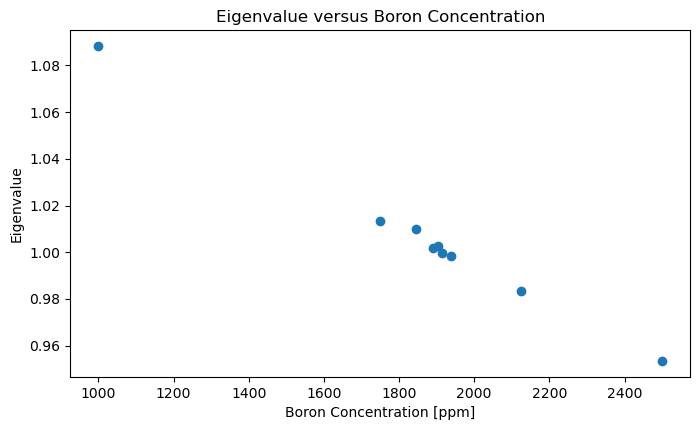

In [7]:
plt.figure(figsize=(8, 4.5))
plt.title('Eigenvalue versus Boron Concentration')
# Create a scatter plot using the mean value of keff
plt.scatter(guesses, [keffs[i].nominal_value for i in range(len(keffs))])
plt.xlabel('Boron Concentration [ppm]')
plt.ylabel('Eigenvalue')
plt.show()